In [4]:
import pandas as pd

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Train_Outpatientdata-1542865627584.csv to Train_Outpatientdata-1542865627584.csv
Saving Train_Inpatientdata-1542865627584.csv to Train_Inpatientdata-1542865627584.csv
Saving Train_Beneficiarydata-1542865627584.csv to Train_Beneficiarydata-1542865627584.csv
Saving Train-1542865627584.csv to Train-1542865627584.csv


In [6]:
claim_label = pd.read_csv("Train_Outpatientdata-1542865627584.csv")
beneficiary = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
inpatient = pd.read_csv("Train_Inpatientdata-1542865627584.csv")
outpatient = pd.read_csv("Train_Outpatientdata-1542865627584.csv")

In [7]:
import pandas as pd

# Load raw CSVs
claim_label = pd.read_csv("Train-1542865627584.csv")
beneficiary = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
inpatient = pd.read_csv("Train_Inpatientdata-1542865627584.csv")
outpatient = pd.read_csv("Train_Outpatientdata-1542865627584.csv")

# Add new features
inpatient["ServiceType"] = "Inpatient"
outpatient["ServiceType"] = "Outpatient"

# Combine claims and merge with beneficiary
claims = pd.concat([inpatient, outpatient], axis=0)
claims = claims.merge(beneficiary, on="BeneID", how="left")

# Merge with fraud labels
claim_label.columns = ["Provider", "PotentialFraud"]
claims = claims.merge(claim_label, on="Provider", how="left")

# Show merged raw claim-level data
print("Merged dataset shape:", claims.shape)
print("Fraud label distribution:\n", claims["PotentialFraud"].value_counts())
print("Preview of merged claim data:")
print(claims.head())

# Aggregate by Provider feature (KEEPING ALL FEATURES)
agg_data = claims.groupby('Provider').agg('first').reset_index()

# Add aggregated statistics manually =
agg_stats = claims.groupby('Provider').agg({
    'ClaimID': 'count',
    'InscClaimAmtReimbursed': ['sum', 'mean', 'std', 'max', 'min'],
    'DeductibleAmtPaid': ['sum', 'mean', 'std', 'max', 'min'],
    'BeneID': pd.Series.nunique,
    'ServiceType': lambda x: (x == 'Inpatient').sum()
})

# Flatten column names
agg_stats.columns = ['_'.join(col).strip('_') for col in agg_stats.columns]
agg_stats = agg_stats.reset_index()

# Merge aggregated statistics back into full agg_data
agg_data = agg_data.merge(agg_stats, on='Provider', how='left')

# Encode label
agg_data['PotentialFraud'] = agg_data['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Final output
print("Final provider-level dataset shape:", agg_data.shape)
print("Fraud label counts:")
print(agg_data['PotentialFraud'].value_counts())
print("Preview of aggregated data:")
print(agg_data.head())
inpatient["ServiceType"] = "Inpatient"
outpatient["ServiceType"] = "Outpatient"

claims = pd.concat([inpatient, outpatient], axis=0)
claims = claims.merge(beneficiary, on="BeneID", how="left")

claim_label.columns = ["Provider", "PotentialFraud"]
claims = claims.merge(claim_label, on="Provider", how="left")

print("Merged dataset shape:", claims.shape)
print("Fraud label distribution:\n", claims["PotentialFraud"].value_counts())

Merged dataset shape: (558211, 56)
Fraud label distribution:
 PotentialFraud
No     345415
Yes    212796
Name: count, dtype: int64
Preview of merged claim data:
      BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11014  CLM63689   2009-08-13  2009-08-30  PRV56614   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   
2                    5000          PHY372395                NaN   
3                    5000          PHY369659          PHY392961   
4                   10000          PHY379376          PHY398258   

  OtherPhysician AdmissionDt  ... ChronicCond_Diabetes  \
0          

In [8]:
# Summary info
print("Total providers (rows):", agg_data.shape[0])
print("Total features (excluding Provider and label):", agg_data.shape[1] - 2)

fraud_counts = agg_data['PotentialFraud'].value_counts()
print("Non-Fraud (0):", fraud_counts.get(0, 0))
print("Fraud (1):", fraud_counts.get(1, 0))


Total providers (rows): 5410
Total features (excluding Provider and label): 67
Non-Fraud (0): 4904
Fraud (1): 506


In [9]:
import numpy as np

data = agg_data.copy()

# DROP UNNECESSARY COLUMNS (IDs, dates, codes, physician names...)
drop_cols = [
    'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt',
    'DischargeDt', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode'
]

# Drop all ICD diagnosis and procedure code columns
drop_cols += [col for col in data.columns if 'ClmDiagnosisCode' in col or 'ClmProcedureCode' in col]

# Drop physician name columns
drop_cols += ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# Drop date of birth and date of death
drop_cols += ['DOB', 'DOD']

data.drop(columns=drop_cols, inplace=True, errors='ignore')

# ENCODE CATEGORICAL VARIABLES
categorical_cols = ['Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'ServiceType']
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].astype('category').cat.codes

print("Cleaned dataset shape:", data.shape)
print("Remaining missing values:", data.isnull().sum().sum())
print("Preview of cleaned data:")
print(data.head())

Cleaned dataset shape: (5410, 40)
Remaining missing values: 489
Preview of cleaned data:
   Provider  InscClaimAmtReimbursed  DeductibleAmtPaid  ServiceType  Gender  \
0  PRV51001                   36000             1068.0            0       0   
1  PRV51003                   14000             1068.0            0       0   
2  PRV51004                     500                0.0            1       1   
3  PRV51005                     200                0.0            1       0   
4  PRV51007                    6000             1068.0            0       1   

   Race  RenalDiseaseIndicator  State  County  NoOfMonths_PartACov  ...  \
0     0                      0      0      77                   12  ...   
1     1                      1     10      58                   12  ...   
2     0                      0     22      34                   12  ...   
3     1                      1      0      54                   12  ...   
4     0                      0      0      69                

In [10]:
# Identify columns with missing values
missing_cols = data.columns[data.isnull().any()].tolist()

print("Columns with missing values:", missing_cols)

# Fill missing values with median (for numeric columns)
for col in missing_cols:
    if data[col].dtype in ['float64', 'int64']:
        median_value = data[col].median()
        data[col].fillna(median_value, inplace=True)
        print(f"Filled NaNs in {col} with median: {median_value}")
    else:
        print(f"Skipped {col} (not numeric)")

# Step 3: Confirm cleaning
print("\Remaining missing values after cleaning:", data.isnull().sum().sum())

Columns with missing values: ['DeductibleAmtPaid', 'InscClaimAmtReimbursed_std', 'DeductibleAmtPaid_mean', 'DeductibleAmtPaid_std', 'DeductibleAmtPaid_max', 'DeductibleAmtPaid_min']
Filled NaNs in DeductibleAmtPaid with median: 0.0
Filled NaNs in InscClaimAmtReimbursed_std with median: 714.121955497346
Filled NaNs in DeductibleAmtPaid_mean with median: 4.285714285714286
Filled NaNs in DeductibleAmtPaid_std with median: 16.145847942957392
Filled NaNs in DeductibleAmtPaid_max with median: 100.0
Filled NaNs in DeductibleAmtPaid_min with median: 0.0
\Remaining missing values after cleaning: 0


<ipython-input-10-ab6f2759a7f7>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_value, inplace=True)


In [11]:
# Correct fillna syntax to avoid future warning
for col in missing_cols:
    if data[col].dtype in ['float64', 'int64']:
        median_value = data[col].median()
        data[col] = data[col].fillna(median_value)  # safer assignment
        print(f"Filled NaNs in {col} with median: {median_value}")

# Double check
print("All missing values filled:", data.isnull().sum().sum() == 0)

# Save cleaned version to file
data.to_csv("agg_train_cleaned_v2.csv", index=False)

# Download to your machine
from google.colab import files
files.download("agg_train_cleaned_v2.csv")


Filled NaNs in DeductibleAmtPaid with median: 0.0
Filled NaNs in InscClaimAmtReimbursed_std with median: 714.121955497346
Filled NaNs in DeductibleAmtPaid_mean with median: 4.285714285714286
Filled NaNs in DeductibleAmtPaid_std with median: 16.145847942957392
Filled NaNs in DeductibleAmtPaid_max with median: 100.0
Filled NaNs in DeductibleAmtPaid_min with median: 0.0
All missing values filled: True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = data.copy()
sns.set(style="whitegrid")

In [ ]:
# Select some key numeric features to visualize
boxplot_features = [
    'InscClaimAmtReimbursed', 'DeductibleAmtPaid',
    'ClaimID_count', 'InscClaimAmtReimbursed_mean',
    'DeductibleAmtPaid_mean', 'BeneID_nunique'
]

# Plot boxplots by fraud status
for feature in boxplot_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='PotentialFraud', y=feature, data=df)
    plt.title(f'{feature} by PotentialFraud')
    plt.xlabel("PotentialFraud (0 = No, 1 = Yes)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


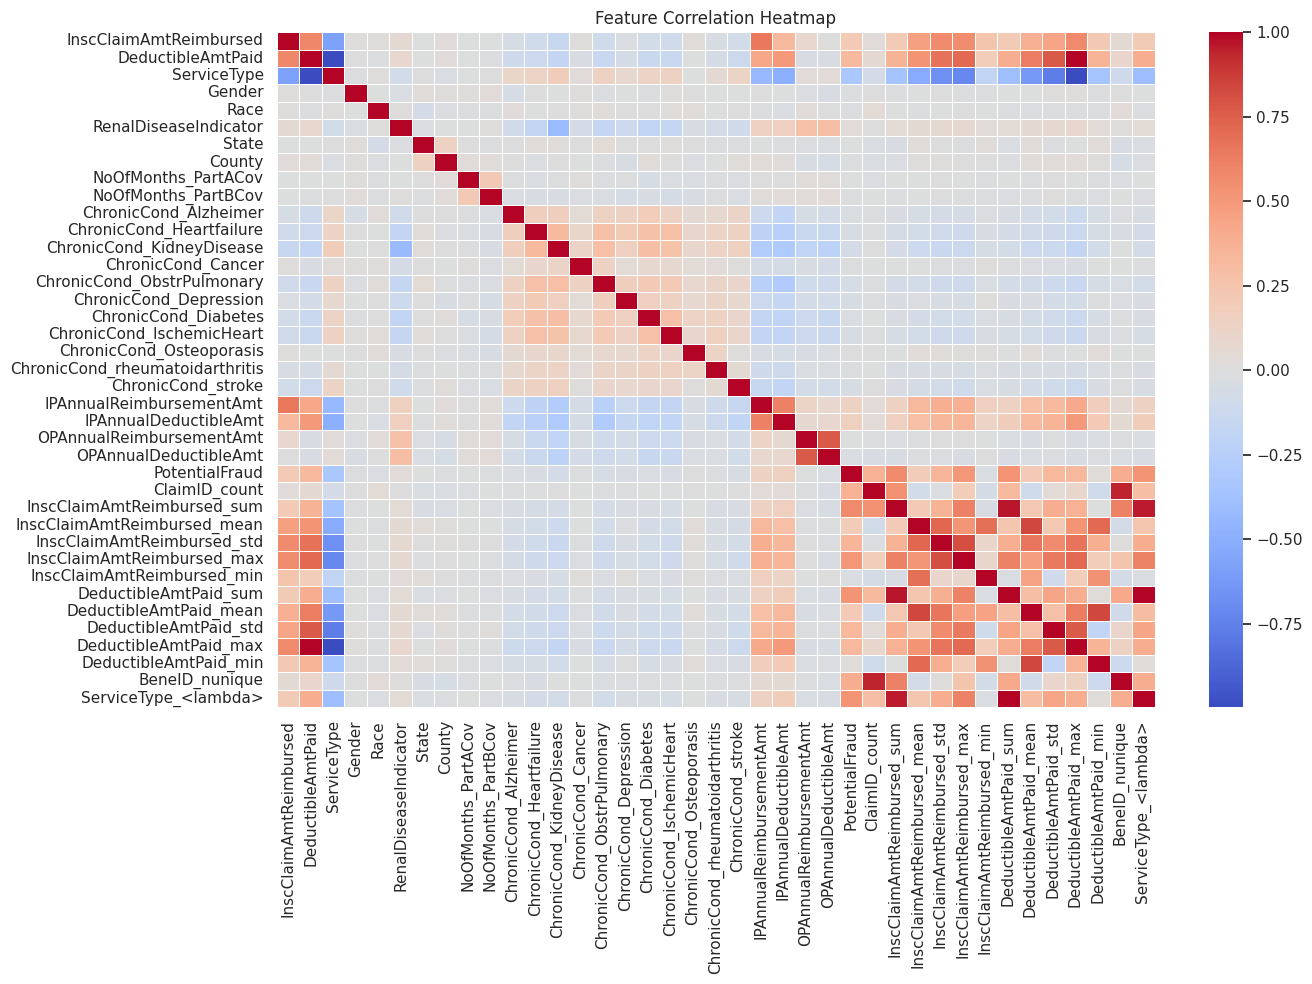

In [ ]:
# Calculate correlation matrix (numerical only)
corr = df.drop(columns=['Provider']).corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/MyDrive/agg_train_cleaned_v2.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-7-371f22f7019f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='PotentialFraud', data=data, palette='Set2')


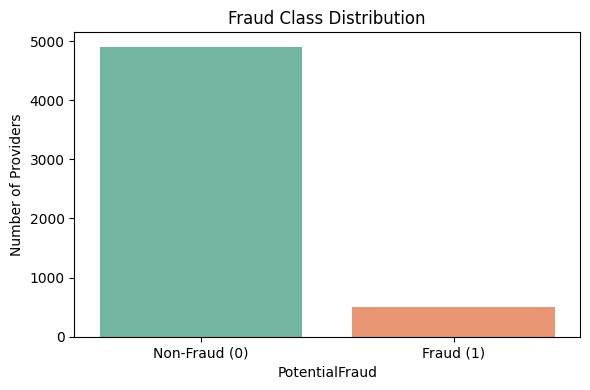

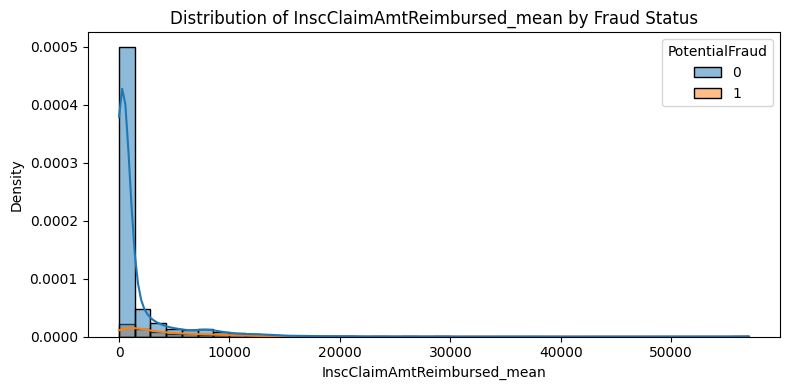

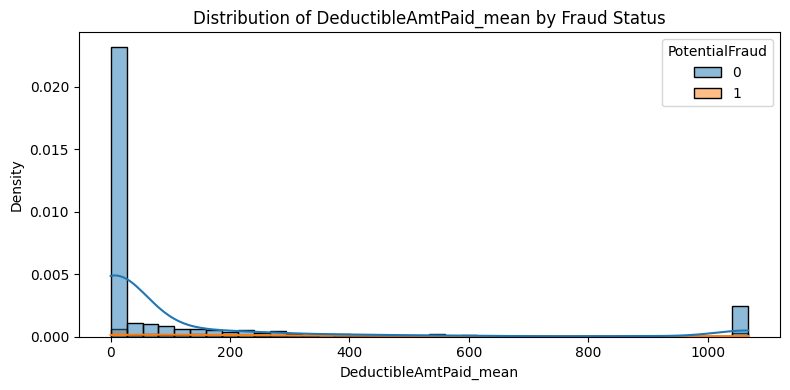

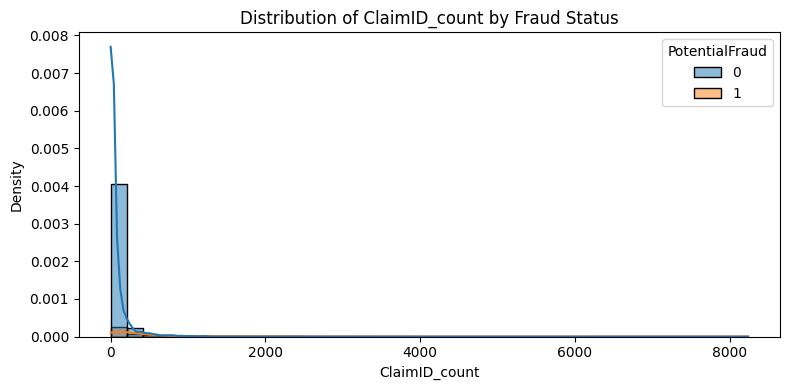

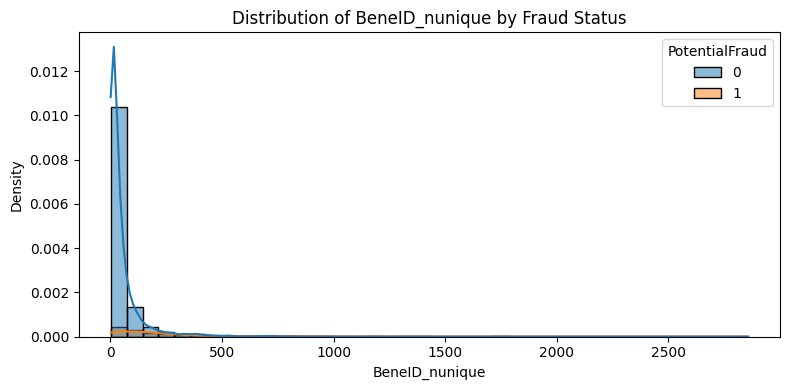

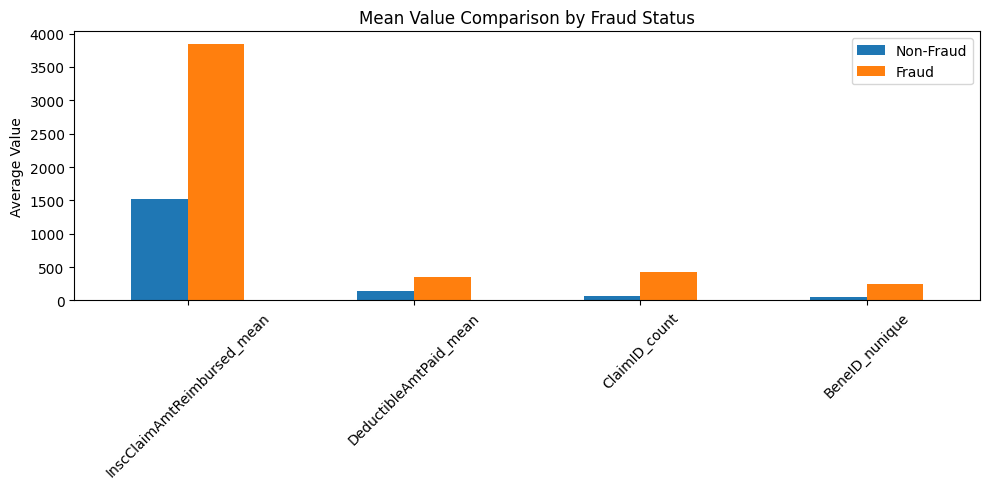

In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fraud class distribution barplot
plt.figure(figsize=(6, 4))
sns.countplot(x='PotentialFraud', data=data, palette='Set2')
plt.title("Fraud Class Distribution")
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.ylabel("Number of Providers")
plt.tight_layout()
plt.show()

# Distribution plots (histogram + KDE)
important_features = [
    'InscClaimAmtReimbursed_mean',
    'DeductibleAmtPaid_mean',
    'ClaimID_count',
    'BeneID_nunique'
]

for feature in important_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=feature, hue="PotentialFraud", bins=40, kde=True, stat="density")
    plt.title(f"Distribution of {feature} by Fraud Status")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

# Compare mean values across fraud classes
grouped_means = data.groupby('PotentialFraud')[important_features].mean().T
grouped_means.columns = ['Non-Fraud', 'Fraud']

grouped_means.plot(kind='bar', figsize=(10, 5))
plt.title("Mean Value Comparison by Fraud Status")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


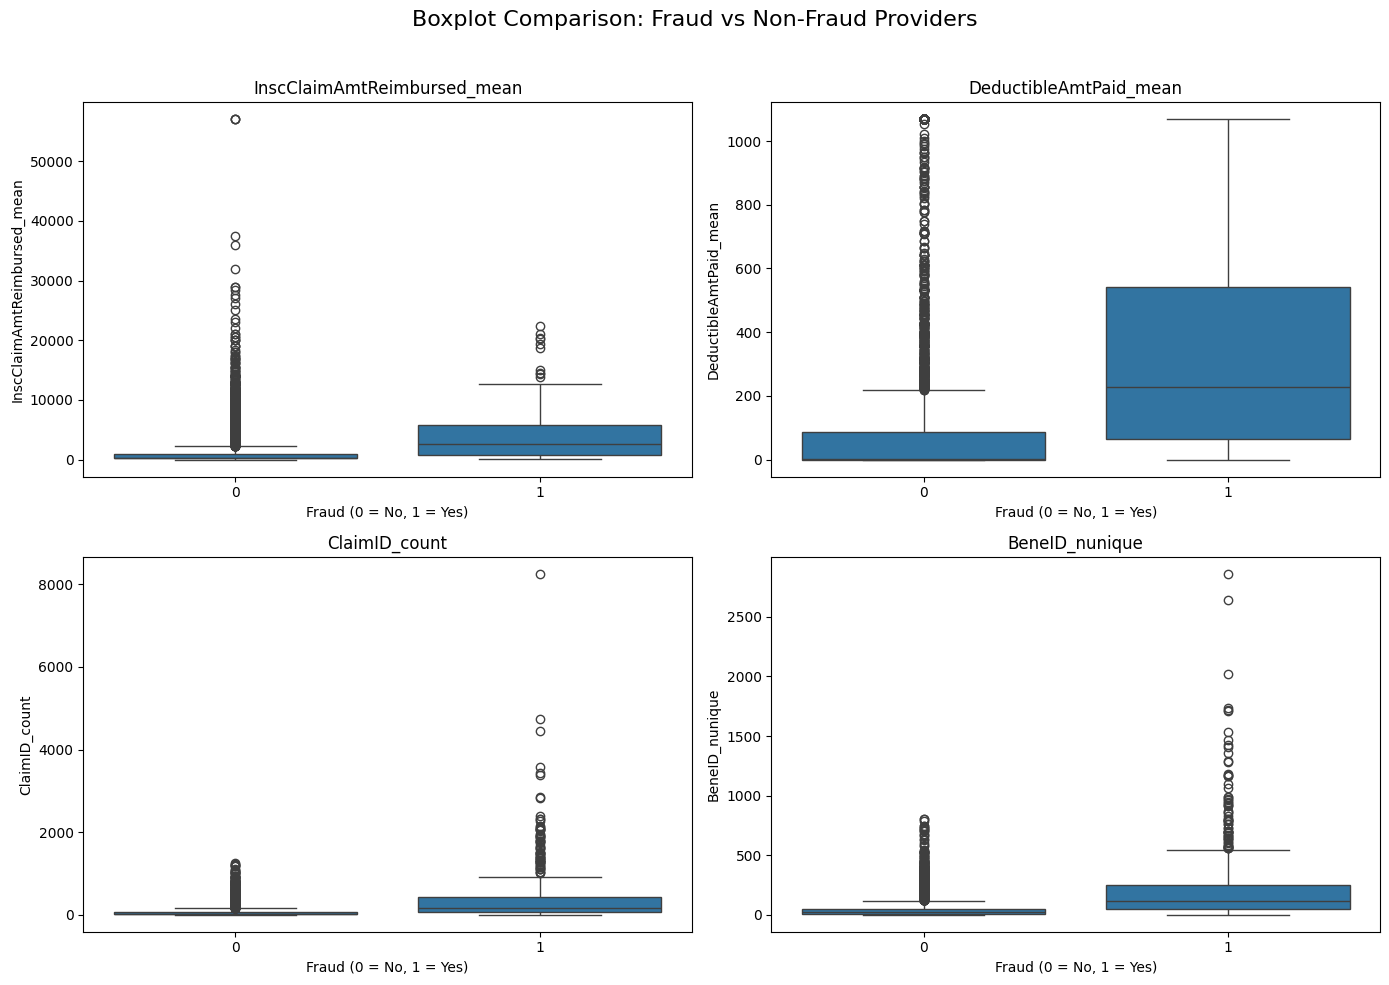

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    'InscClaimAmtReimbursed_mean',
    'DeductibleAmtPaid_mean',
    'ClaimID_count',
    'BeneID_nunique'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Boxplot Comparison: Fraud vs Non-Fraud Providers", fontsize=16)

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.boxplot(x='PotentialFraud', y=feature, data=data, ax=axes[row][col])
    axes[row][col].set_title(feature)
    axes[row][col].set_xlabel("Fraud (0 = No, 1 = Yes)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Create engineered features
import numpy as np
data["ReimbPerClaim"] = data["InscClaimAmtReimbursed_sum"] / (data["ClaimID_count"] + 1)
data["ReimbPerPatient"] = data["InscClaimAmtReimbursed_sum"] / (data["BeneID_nunique"] + 1)
data["ClaimPerPatient"] = data["ClaimID_count"] / (data["BeneID_nunique"] + 1)
data["HighDeductibleFlag"] = (data["DeductibleAmtPaid_mean"] > 500).astype(int)

# log-transform highly skewed variables
for col in ["InscClaimAmtReimbursed_sum", "ClaimID_count", "BeneID_nunique"]:
    data[f"log_{col}"] = np.log1p(data[col])

# Save new featured dataset
data.to_csv("agg_train_featured.csv", index=False)

# Download (if needed)
from google.colab import files
files.download("agg_train_featured.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving agg_train_featured.csv to agg_train_featured.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb

# Load data
data = pd.read_csv("agg_train_featured.csv")

# Prepare features and target
X = data.drop(columns=["Provider", "PotentialFraud"])
y = data["PotentialFraud"]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=12345)

# Clean feature names
X_train.columns = X_train.columns.str.replace('[\[\]<>]', '', regex=True)
X_val.columns = X_val.columns.str.replace('[\[\]<>]', '', regex=True)

# Define base models
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=12345)
hgb = HistGradientBoostingClassifier(max_iter=100, class_weight='balanced', random_state=12345)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3, random_state=12345)

# Fit base models
rf.fit(X_train, y_train)
hgb.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Define Voting Ensemble
voting = VotingClassifier(
    estimators=[('rf', rf), ('hgb', hgb), ('xgb', xgb_model)],
    voting='soft'
)
voting.fit(X_train, y_train)

# Predict probabilities for F1-weighted ensemble
proba_hgb = hgb.predict_proba(X_val)[:, 1]
proba_vote = voting.predict_proba(X_val)[:, 1]

# Calculate validation F1 scores for weighting
f1_hgb = f1_score(y_val, hgb.predict(X_val))
f1_vote = f1_score(y_val, voting.predict(X_val))

# Normalize weights
total = f1_hgb + f1_vote
w_hgb = f1_hgb / total
w_vote = f1_vote / total

# F1-weighted final prediction
final_proba = w_hgb * proba_hgb + w_vote * proba_vote
final_pred = (final_proba > 0.5).astype(int)

print("Models trained and F1-weighted ensemble complete.")
print(f"F1 HGB: {f1_hgb:.4f} | F1 Voting: {f1_vote:.4f}")
print(f"Final weighted prediction F1: {f1_score(y_val, final_pred):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Models trained and F1-weighted ensemble complete.
F1 HGB: 0.5248 | F1 Voting: 0.5029
Final weighted prediction F1: 0.5297


Top features (importance > 0.01):
log_InscClaimAmtReimbursed_sum    0.149908
InscClaimAmtReimbursed_sum        0.128026
DeductibleAmtPaid_sum             0.084561
ReimbPerPatient                   0.049539
ServiceType_<lambda>              0.045473
InscClaimAmtReimbursed_std        0.039920
InscClaimAmtReimbursed_max        0.038395
DeductibleAmtPaid_max             0.036630
log_ClaimID_count                 0.035015
ClaimID_count                     0.033443
ReimbPerClaim                     0.030006
ClaimPerPatient                   0.029833
DeductibleAmtPaid_mean            0.028854
log_BeneID_nunique                0.028318
DeductibleAmtPaid_std             0.026656
BeneID_nunique                    0.025877
InscClaimAmtReimbursed_mean       0.025417
InscClaimAmtReimbursed            0.025353
County                            0.016872
IPAnnualReimbursementAmt          0.016552
OPAnnualReimbursementAmt          0.015354
State                             0.014696
OPAnnualDeductibleAm

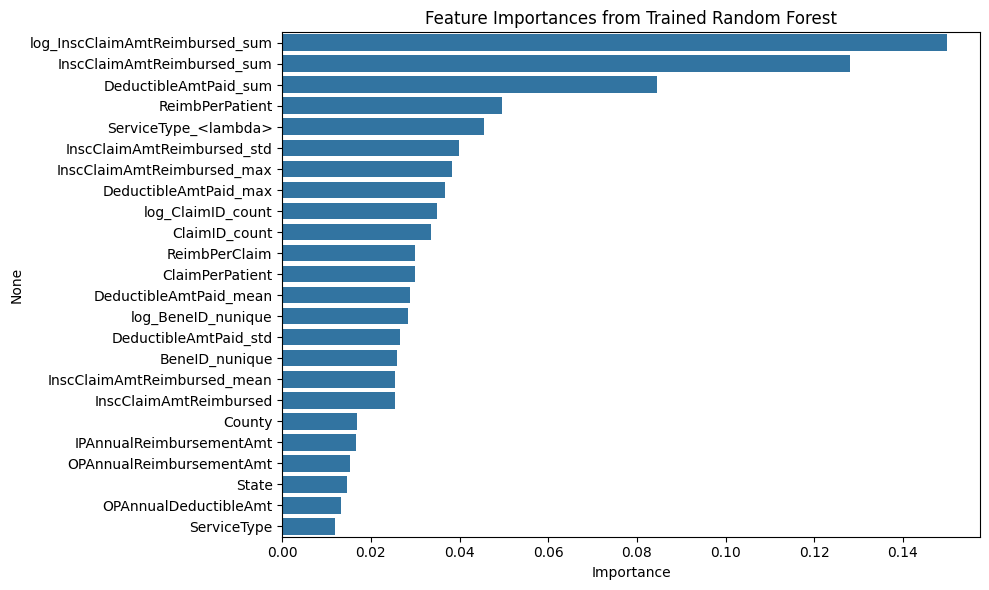

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features (importance > 0.01):")
print(importances[importances > 0.01])
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[importances > 0.01], y=importances[importances > 0.01].index)
plt.title("Feature Importances from Trained Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, average_precision_score
models = {
    'Random Forest': rf,
    'HGB': hgb,
    'XGBoost': xgb_model,
    'Voting': voting
}

f1_scores = {}

for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_proba)

    f1_scores[name] = f1
    print(f"{name}: F1-score = {f1:.4f} | PR-AUC = {pr_auc:.4f}")

Random Forest: F1-score = 0.4933 | PR-AUC = 0.6282
HGB: F1-score = 0.5248 | PR-AUC = 0.6171
XGBoost: F1-score = 0.4800 | PR-AUC = 0.6000
Voting: F1-score = 0.5029 | PR-AUC = 0.6267


In [ ]:
from sklearn.metrics import classification_report, average_precision_score

print("Final Weighted Ensemble Evaluation")
print(classification_report(y_val, final_pred, digits=4))
print("PR-AUC:", average_precision_score(y_val, final_proba))

Final Weighted Ensemble Evaluation
              precision    recall  f1-score   support

           0     0.9479    0.9643    0.9560       981
           1     0.5833    0.4851    0.5297       101

    accuracy                         0.9196      1082
   macro avg     0.7656    0.7247    0.7429      1082
weighted avg     0.9139    0.9196    0.9162      1082

PR-AUC: 0.6236967558461337


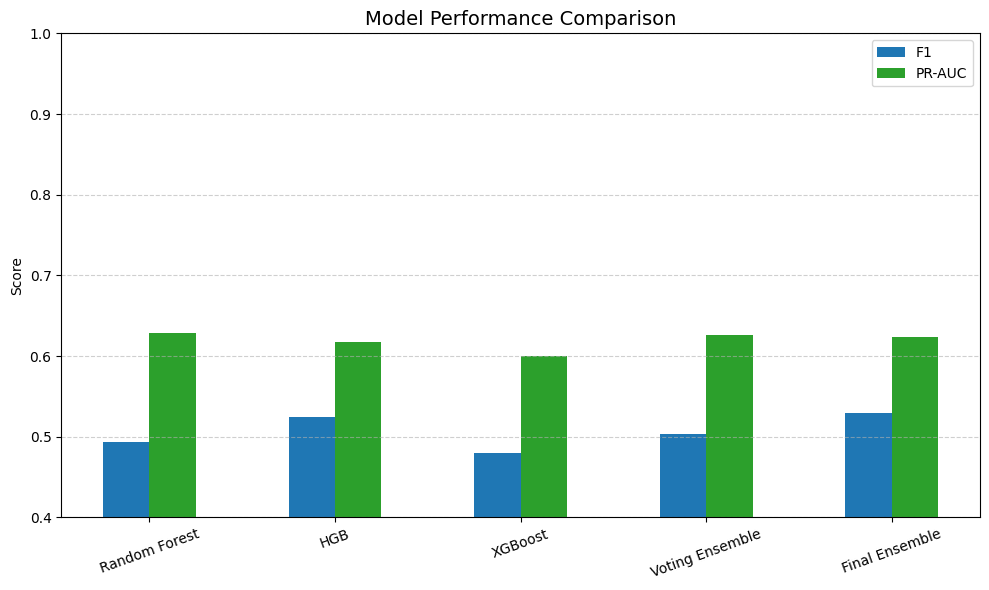

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, average_precision_score

models = {
    'Random Forest': rf,
    'HGB': hgb,
    'XGBoost': xgb_model,
    'Voting Ensemble': voting
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_proba)

    results.append({
        'Model': name,
        'F1': round(f1, 4),
        'PR-AUC': round(pr_auc, 4)
    })

f1_final = f1_score(y_val, final_pred)
pr_auc_final = average_precision_score(y_val, final_proba)

results.append({
    'Model': 'Final Ensemble',
    'F1': round(f1_final, 4),
    'PR-AUC': round(pr_auc_final, 4)
})

results_df = pd.DataFrame(results)

df_long = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
metrics = df_long['Metric'].unique()
colors = ['#1f77b4', '#2ca02c']
bar_width = 0.25
x = np.arange(len(results_df))

for i, metric in enumerate(metrics):
    scores = results_df[metric]
    plt.bar(x + i * bar_width, scores, width=bar_width, label=metric, color=colors[i])

plt.xticks(x + bar_width / 2, results_df['Model'], rotation=20)
plt.ylim(0.4, 1.0)
plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
print(results_df)

             Model      F1  PR-AUC
0    Random Forest  0.4933  0.6282
1              HGB  0.5248  0.6171
2          XGBoost  0.4800  0.6000
3  Voting Ensemble  0.5029  0.6267
4   Final Ensemble  0.5297  0.6237


In [ ]:
!pip install shap
!pip install lime
import shap
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1bec5c42fc06808cc518024db18f9bdbf37b1db976621098badcf7babb22a738
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
globals().keys()


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'files', 'uploaded', '_i2', 'pd', 'np', 'RandomForestClassifier', 'HistGradientBoostingClassifier', 'VotingClassifier', 'train_test_split', 'f1_score', 'xgb', 'data', 'X', 'y', 'X_train', 'X_val', 'y_train', 'y_val', 'rf', 'hgb', 'xgb_model', 'voting', 'proba_hgb', 'proba_vote', 'f1_hgb', 'f1_vote', 'total', 'w_hgb', 'w_vote', 'final_proba', 'final_pred', '_i3', 'importances', 'plt', 'sns', '_i4', 'models', 'f1_scores', 'name', 'model', 'y_pred', 'y_proba', 'f1', '_i5', 'average_precision_score', 'pr_auc', '_i6', 'classification_report', '_i7', 'results', 'f1_final', 'pr_auc_final', 'results_df', 'df_long', 'metrics', 'colors', 'bar_width', 'x', 'i', 'metric', 'scores', '_i8', '_exit_code', 'shap', 'lime', 'PartialDependenceDisplay', 'warnings', '_i9'])

 99%|===================| 5348/5410 [00:46<00:00]       

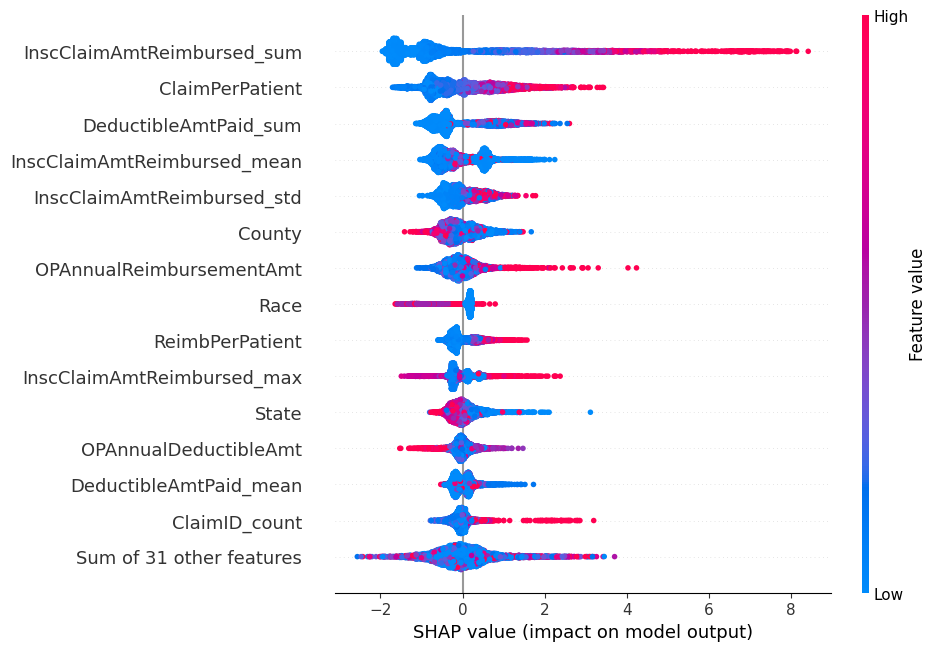

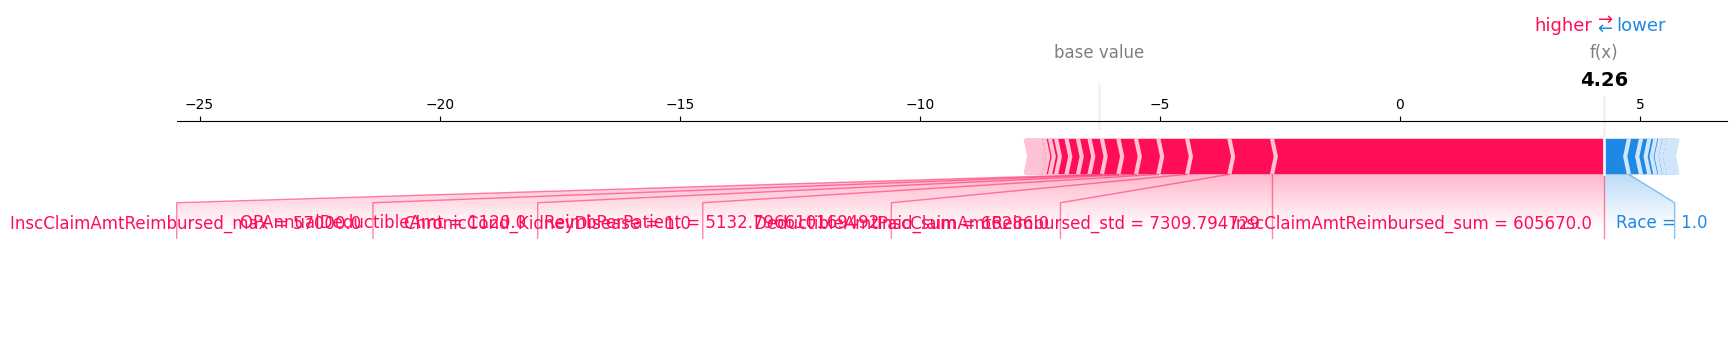

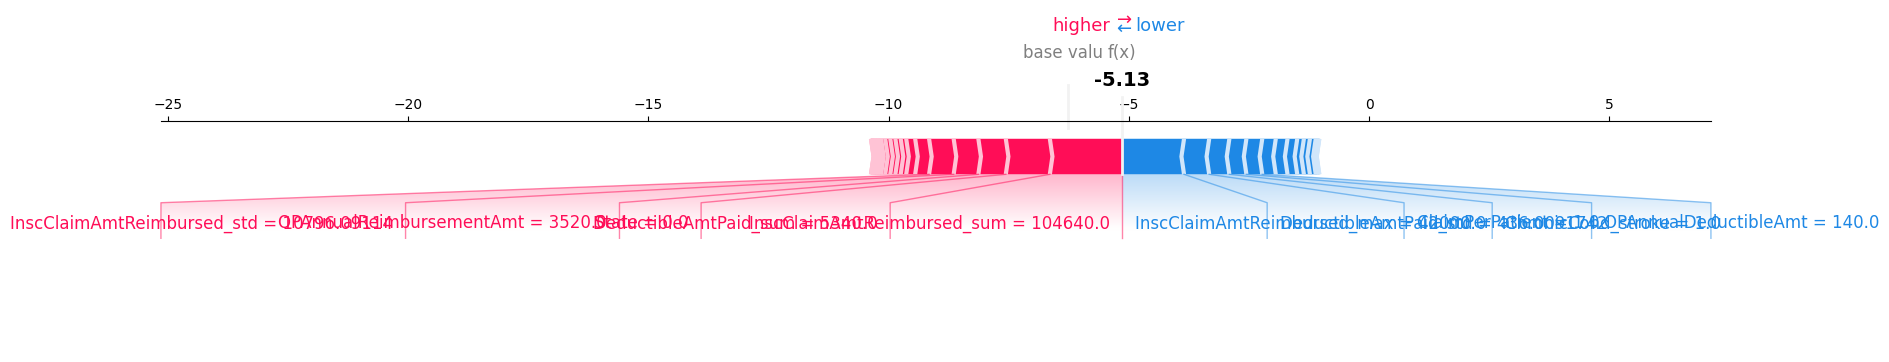

In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np

fraud_idx = np.where(y.values == 1)[0][0]
nonfraud_idx = np.where(y.values == 0)[0][0]

X_fraud = X.iloc[[fraud_idx]]
X_nonfraud = X.iloc[[nonfraud_idx]]

explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values, max_display=15)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[fraud_idx].values, X.iloc[fraud_idx], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[nonfraud_idx].values, X.iloc[nonfraud_idx], matplotlib=True)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=X.columns.tolist(),
    class_names=['Non-Fraud', 'Fraud'],
    mode='classification'
)

for i in [fraud_idx, nonfraud_idx]:
    exp = lime_explainer.explain_instance(
        data_row=X.iloc[i].values,
        predict_fn=xgb_model.predict_proba,
        num_features=10
    )
    exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
import time
import numpy as np
import pandas as pd
import gc
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_recall_curve

# Fit RF base model for feature ranking
rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=12345)
rf_base.fit(X_train, y_train)

importances = rf_base.feature_importances_
feature_names = np.array(X_train.columns)
sorted_idx = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_idx]

max_k = 40
repeat_n = 3

results_k = {'Random Forest': [], 'HGB': [], 'Ensemble': []}

def optimal_f1_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1s = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx]

for k in range(1, max_k + 1):
    top_k = sorted_features[:k]
    X_train_k = X_train[top_k]
    X_val_k = X_val[top_k]

    metrics_rf, metrics_hgb, metrics_ens = [], [], []

    for _ in range(repeat_n):
        rf_k = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=12345)
        start = time.time()
        rf_k.fit(X_train_k, y_train)
        fit_rf = time.time() - start

        start = time.time()
        proba_rf = rf_k.predict_proba(X_val_k)[:, 1]
        thresh_rf = optimal_f1_threshold(y_val, proba_rf)
        pred_rf = (proba_rf >= thresh_rf).astype(int)
        pred_rf_time = time.time() - start

        metrics_rf.append([
            f1_score(y_val, pred_rf),
            roc_auc_score(y_val, proba_rf),
            average_precision_score(y_val, proba_rf),
            fit_rf, pred_rf_time
        ])

        hgb_k = HistGradientBoostingClassifier(max_iter=100, random_state=12345)
        start = time.time()
        hgb_k.fit(X_train_k, y_train)
        fit_hgb = time.time() - start

        start = time.time()
        proba_hgb = hgb_k.predict_proba(X_val_k)[:, 1]
        thresh_hgb = optimal_f1_threshold(y_val, proba_hgb)
        pred_hgb = (proba_hgb >= thresh_hgb).astype(int)
        pred_hgb_time = time.time() - start

        metrics_hgb.append([
            f1_score(y_val, pred_hgb),
            roc_auc_score(y_val, proba_hgb),
            average_precision_score(y_val, proba_hgb),
            fit_hgb, pred_hgb_time
        ])

        f1_rf = metrics_rf[-1][0]
        f1_hgb = metrics_hgb[-1][0]
        w_rf = f1_rf / (f1_rf + f1_hgb) if f1_rf + f1_hgb > 0 else 0.5
        w_hgb = 1 - w_rf

        start = time.time()
        proba_ens = w_rf * proba_rf + w_hgb * proba_hgb
        thresh_ens = optimal_f1_threshold(y_val, proba_ens)
        pred_ens = (proba_ens >= thresh_ens).astype(int)
        pred_ens_time = time.time() - start

        metrics_ens.append([
            f1_score(y_val, pred_ens),
            roc_auc_score(y_val, proba_ens),
            average_precision_score(y_val, proba_ens),
            0.0, pred_ens_time
        ])

        del rf_k, hgb_k, proba_rf, proba_hgb, proba_ens
        gc.collect()

    def avg(lst, idx): return np.mean([x[idx] for x in lst])

    results_k['Random Forest'].append({
        'k': k,
        'F1': avg(metrics_rf, 0),
        'AUC': avg(metrics_rf, 1),
        'PR-AUC': avg(metrics_rf, 2),
        'FitTime': avg(metrics_rf, 3),
        'PredictTime': avg(metrics_rf, 4),
        'TotalTime': avg(metrics_rf, 3) + avg(metrics_rf, 4)
    })

    results_k['HGB'].append({
        'k': k,
        'F1': avg(metrics_hgb, 0),
        'AUC': avg(metrics_hgb, 1),
        'PR-AUC': avg(metrics_hgb, 2),
        'FitTime': avg(metrics_hgb, 3),
        'PredictTime': avg(metrics_hgb, 4),
        'TotalTime': avg(metrics_hgb, 3) + avg(metrics_hgb, 4)
    })

    results_k['Ensemble'].append({
        'k': k,
        'F1': avg(metrics_ens, 0),
        'AUC': avg(metrics_ens, 1),
        'PR-AUC': avg(metrics_ens, 2),
        'FitTime': 0.0,
        'PredictTime': avg(metrics_ens, 4),
        'TotalTime': avg(metrics_ens, 4)
    })

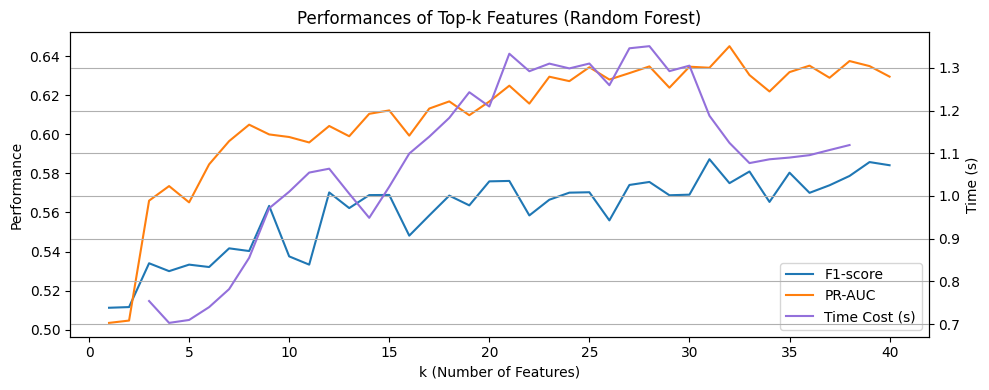

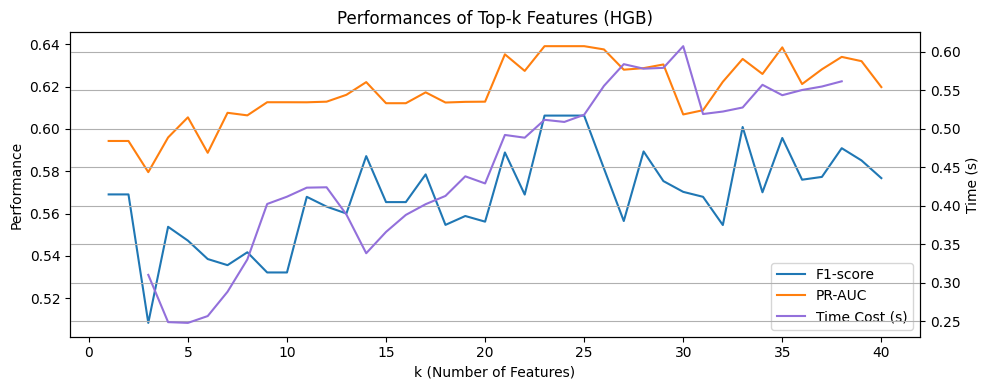

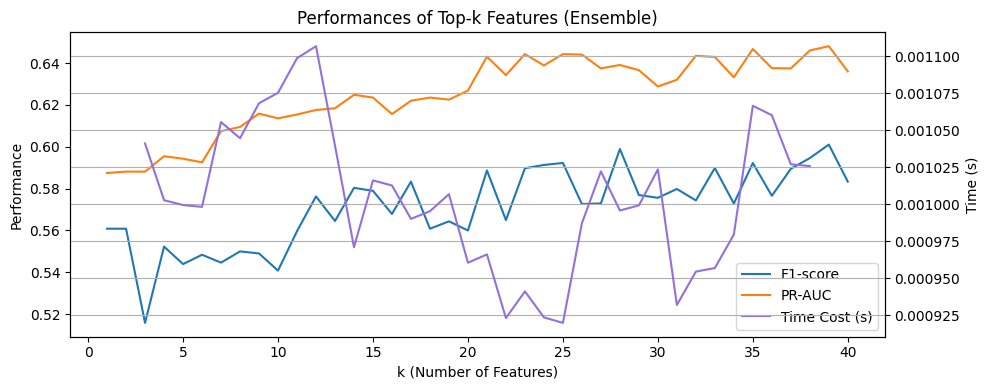

In [ ]:
import matplotlib.pyplot as plt

for model_name, records in results_k.items():
    df = pd.DataFrame(records)
    df['SmoothTime'] = df['TotalTime'].rolling(window=5, center=True).mean()

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax2 = ax1.twinx()

    ax1.plot(df['k'], df['F1'], label='F1-score')
    ax1.plot(df['k'], df['PR-AUC'], label='PR-AUC')
    ax2.plot(df['k'], df['SmoothTime'], label='Time Cost (s)', color='mediumpurple')

    ax1.set_xlabel('k (Number of Features)')
    ax1.set_ylabel('Performance')
    ax2.set_ylabel('Time (s)')
    ax1.set_title(f'Performances of Top-k Features ({model_name})')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

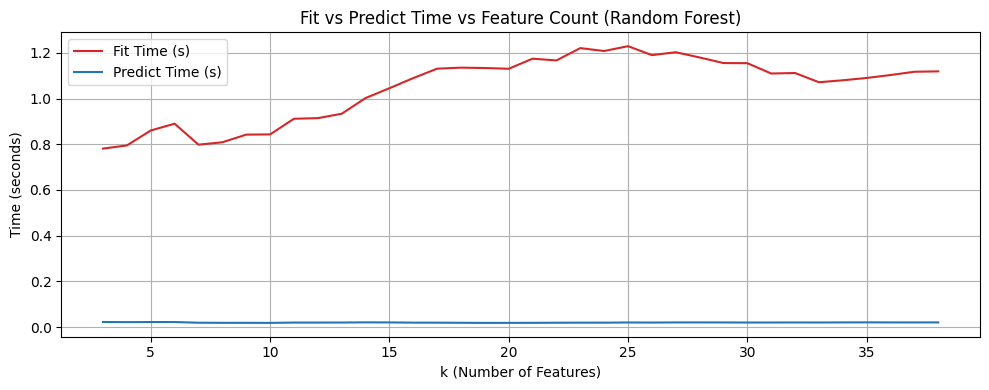

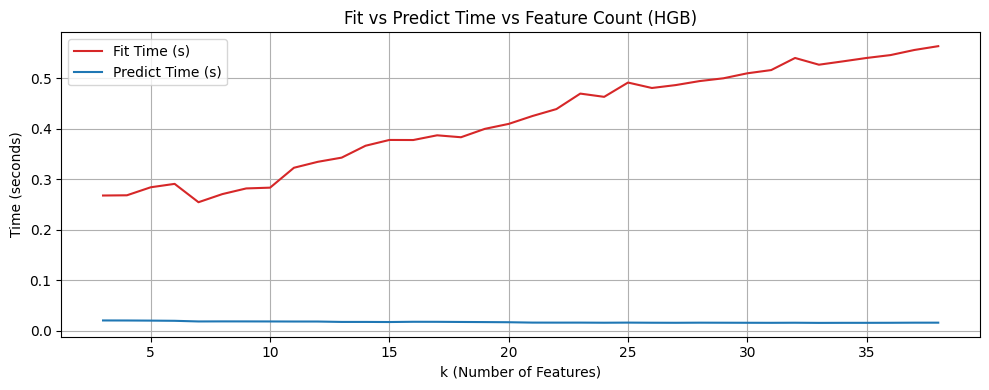

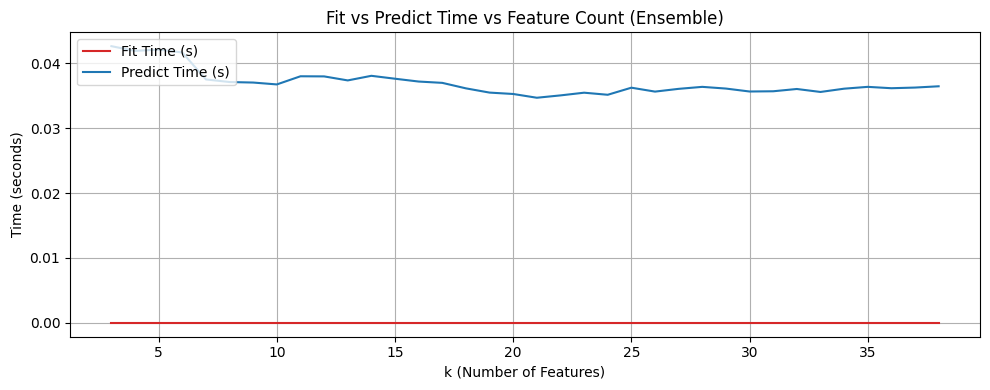

In [ ]:
import matplotlib.pyplot as plt

for model_name, records in results_k.items():
    df = pd.DataFrame(records)
    df['SmoothFit'] = df['FitTime'].rolling(window=5, center=True).mean()
    df['SmoothPred'] = df['PredictTime'].rolling(window=5, center=True).mean()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df['k'], df['SmoothFit'], label='Fit Time (s)', color='tab:red')
    ax.plot(df['k'], df['SmoothPred'], label='Predict Time (s)', color='tab:blue')

    ax.set_xlabel('k (Number of Features)')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Fit vs Predict Time vs Feature Count ({model_name})')
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()